# Potential Outcomes & Randomization Inference – Mixtape em Python

Este notebook reproduz e comenta exemplos centrais do capítulo
**Potential Outcomes Causal Model** do livro
*Causal Inference: The Mixtape*, de Scott Cunningham (Yale University Press, 2021).

A ideia é mostrar, passo a passo, como ligar:

- a notação de **resultados potenciais**;
- a diferença de médias como estimador do **ATE**;
- a lógica de **randomização física** (Fisher);
- a **randomization inference** sob o *sharp null*;
- a comparação de distribuições (teste de Kolmogorov–Smirnov);
- e, por fim, **p-values aproximados** quando o número de combinações explode.

Sempre que possível, conectamos explicitamente o código à teoria e
às fórmulas, para que fique claro *por que* cada passo é feito daquele jeito.

## 0. Setup e convenções

Vamos usar:

- `pandas` e `numpy` para dados e simulações;
- `statsmodels` para regressão OLS;
- `matplotlib` para gráficos;
- `itertools` para gerar todas as atribuições possíveis em exemplos pequenos.

Também fixamos uma semente para reprodutibilidade:

- isso é importante quando simulamos aleatoriedade, porque queremos que
  quem rodar o código veja os mesmos números.

In [22]:
import math
from itertools import combinations, permutations
from typing import Iterable, Tuple, List

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

### Semente global e URLs dos dados

Os datasets são exatamente os usados pelo Mixtape, hospedados no GitHub do autor.


In [23]:
RANDOM_SEED = 91
np.random.seed(RANDOM_SEED)

# URLs dos dados usados no Mixtape
YULE_URL = "https://github.com/scunning1975/mixtape/raw/master/yule.dta"
RI_URL = "https://github.com/scunning1975/mixtape/raw/master/ri.dta"
THORNTON_HIV_URL = "https://github.com/scunning1975/mixtape/raw/master/thornton_hiv.dta"


## 1. Yule: regressão OLS e por que **não** é automaticamente causal

O exemplo clássico de Yule estuda a associação entre:

- crescimento do pauperismo (`paup`);
- gasto em assistência pública (`outrelief`);
- controles (`old`, `pop`).

O modelo estimado é:

$$
\text{paup}_i = \beta_0 + \beta_1\,\text{outrelief}_i + \beta_2\,\text{old}_i + \beta_3\,\text{pop}_i + \varepsilon_i.
$$

Se fôssemos ingênuos, poderíamos tentar ler $\beta_1$ como um efeito causal da
assistência pública sobre o crescimento do pauperismo.

Mas, como o próprio Cunningham enfatiza:

- é um **estudo observacional**, com poucos controles;
- é plausível que existam confundidores não observados (economia local, choques etc.);
- é plausível que a causalidade seja ao contrário (mais pobreza → mais gasto).

Então, este bloco serve para:

1. Rodar a regressão tal como no livro;
2. Ilustrar a *diferença entre associação e causalidade*.

In [24]:
def load_yule_data(url: str = YULE_URL) -> pd.DataFrame:
    """
    Carrega o dataset de Yule, com informações sobre pauperismo na Inglaterra.

    Colunas típicas:
    - paup      : crescimento do pauperismo (% ao ano)
    - outrelief : crescimento no gasto em assistência pública
    - old       : crescimento da população idosa
    - pop       : crescimento da população total

    Fonte: Cunningham, "Causal Inference: The Mixtape", tabela de Yule.
    """
    yule = pd.read_stata(url)
    return yule


def run_yule_regression(
    yule: pd.DataFrame,
) -> sm.regression.linear_model.RegressionResultsWrapper:
    """
    Ajusta uma regressão OLS de pauperismo sobre assistência pública e controles.

    Modelo:
        paup = β0 + β1 * outrelief + β2 * old + β3 * pop + ε

    Pergunta central:
        β1 pode ser interpretado como efeito causal da assistência
        pública no crescimento do pauperismo?

    Retorna o objeto de resultados do statsmodels.
    """
    model = sm.OLS.from_formula("paup ~ outrelief + old + pop", data=yule)
    results = model.fit()
    return results


def demo_yule_regression() -> None:
    """
    Roda o exemplo de Yule, imprime a regressão e comenta o coeficiente
    de outrelief à luz da distinção correlação vs. causalidade.
    """
    print("\n=== Exemplo Yule: Regressão OLS ===")
    yule = load_yule_data()
    res = run_yule_regression(yule)
    print(res.summary())

    beta_outrelief = res.params["outrelief"]
    se_outrelief = res.bse["outrelief"]

    print("\nInterpretação de 'outrelief':")
    print(
        f"  • β̂_outrelief = {beta_outrelief:.3f} (erro-padrão {se_outrelief:.3f})."
    )
    print(
        "  • No livro, Cunningham lê isso como: um aumento de 10 p.p. em outrelief\n"
        "    está associado a ≈ 7,5 p.p. a mais em pauperism growth – mas destaca que\n"
        "    isso é apenas correlação, não necessariamente efeito causal.\n"
        "  • Para interpretação causal, precisaríamos crer que, condicional em old e pop,\n"
        "    não há mais nenhum confundidor ligando outrelief e paup (o que é implausível)."
    )

## 2. Resultados potenciais e diferença de médias sob randomização

Agora saímos do exemplo observacional e vamos para o coração do
**modelo de resultados potenciais**.

Para cada unidade $i$, definimos:

$$
Y_i(1) = \text{resultado potencial se tratada},
$$

$$
Y_i(0) = \text{resultado potencial se controle}.
$$

O **efeito causal individual** é:

$$
\tau_i = Y_i(1) - Y_i(0),
$$

e o **efeito médio de tratamento (ATE)** é:

$$
\tau = \mathbb{E}[Y(1) - Y(0)].
$$

Mas só observamos um dos dois resultados:

$$
Y_i = D_i\,Y_i(1) + (1 - D_i)\,Y_i(0),
$$

onde $D_i \in \{0,1\}$ é o indicador de tratamento.

O estimador de diferença de médias (SDO) é:

$$
\hat{\tau}^{\text{SDO}} = \bar{Y}_1 - \bar{Y}_0,
$$

onde $\bar{Y}_1$ é a média dos tratados e $\bar{Y}_0$ é a média dos controles.

A grande ideia:

- sob **randomização** (isto é, se $D_i$ é independente de $(Y_i(1), Y_i(0))$),
  temos:

$$
\mathbb{E}[\hat{\tau}^{\text{SDO}}] = \tau.
$$

Vamos simular isso com o mesmo exemplo de 10 unidades usado no *Mixtape*.


In [25]:
def simulate_difference_in_means(
    y1: np.ndarray,
    y0: np.ndarray,
    n_treated: int,
    n_sim: int = 10_000,
    random_seed: int = RANDOM_SEED,
) -> Tuple[float, float]:
    """
    Simula o estimador de diferença de médias (SDO) sob randomização
    de tratamento, e compara com o ATE verdadeiro baseado em
    resultados potenciais.

    Ideia:
    - Temos n unidades e dois vetores:
        y1: resultados potenciais sob tratamento  (Y(1))
        y0: resultados potenciais sob controle    (Y(0))
    - Em cada simulação:
        * sorteamos aleatoriamente n_treated unidades para tratamento
        * observamos y = d * y1 + (1 - d) * y0
        * calculamos diferença de médias ȳ_trat - ȳ_cont
    - Repetimos e comparamos a média dessas diferenças com o ATE verdadeiro.

    Retorna:
        (mean_sdo, ate_true)
    """
    rng = np.random.default_rng(random_seed)
    n = len(y1)
    if n != len(y0):
        raise ValueError("y1 e y0 devem ter o mesmo tamanho.")
    if not (0 < n_treated < n):
        raise ValueError("n_treated deve estar entre 1 e n-1.")

    sdo_list: List[float] = []

    for _ in range(n_sim):
        # Vetor de tratamento (1 para tratado, 0 para controle)
        d = np.concatenate([np.ones(n_treated), np.zeros(n - n_treated)])
        # Embaralha para simular atribuição aleatória
        rng.shuffle(d)

        # Resultado observado
        y = d * y1 + (1 - d) * y0

        mean_treated = y[d == 1].mean()
        mean_control = y[d == 0].mean()
        sdo = mean_treated - mean_control
        sdo_list.append(sdo)

    mean_sdo = float(np.mean(sdo_list))
    ate_true = float(np.mean(y1 - y0))
    return mean_sdo, ate_true


def demo_independence_assumption() -> None:
    """
    Demonstra, com o experimento simples do livro, que sob randomização
    a diferença de médias é não-viesada para o ATE.
    """
    print("\n=== Independência: SDO vs ATE ===")

    # Resultados potenciais (iguais aos do código do Mixtape)
    y1 = np.array([7, 5, 5, 7, 4, 10, 1, 5, 3, 9])
    y0 = np.array([1, 6, 1, 8, 2, 1, 10, 6, 7, 8])

    mean_sdo, ate_true = simulate_difference_in_means(
        y1=y1,
        y0=y0,
        n_treated=5,
        n_sim=10_000,
    )

    print(f"Estimativa média do SDO (simulado): {mean_sdo:.3f}")
    print(f"ATE verdadeiro (média de y1 - y0):  {ate_true:.3f}")
    print(
        "\nIntuição:\n"
        "  • Como o tratamento é atribuído aleatoriamente (independente de Y(1), Y(0)),\n"
        "    a diferença de médias entre grupos é, em média, igual ao ATE verdadeiro.\n"
        "  • É isso que queremos que aconteça em experimentos bem desenhados."
    )

## 3. Lady tasting tea: Fisher, combinações e *exact p-value*

A história da **Dr. Muriel Bristol** (lady tasting tea) é usada por Fisher
como exemplo da lógica de *randomization inference*.

- Existem 8 xícaras de chá;
- Em 4 delas o leite foi colocado primeiro; nas outras 4, o chá;
- Sob a hipótese nula $H_0$ (nenhuma habilidade especial), a resposta dela
  é puro chute.

Quantas maneiras diferentes existem de escolher 4 xícaras dentre 8?

$$
\binom{8}{4} = \frac{8!}{4!4!} = 70.
$$

Sob $H_0$, todas as $\binom{8}{4}$ combinações são igualmente prováveis.
Logo, a probabilidade de acertar exatamente as 4 corretas por sorte é:

$$
P(\text{acertar 4 de 4} \mid H_0)
  = \frac{1}{\binom{8}{4}}
  = \frac{1}{70}
  \approx 0{,}014.
$$

Esse valor é um **p-value exato** para o evento “acertar todas as 4 xícaras”
sob a hipótese de *nenhum poder real*.

Vamos codificar isso de forma explícita.


In [26]:
def tea_tasting_probability(
    n_cups: int = 8,
    n_treated: int = 4,
    guess: Tuple[int, ...] = (1, 2, 3, 4),
) -> float:
    """
    Calcula a probabilidade de Dr. Bristol acertar exatamente os 'n_treated'
    copos "tratados" (por exemplo, leite primeiro) se estivesse apenas chutando.

    Por construção:
        P(acerto perfeito) = 1 / C(n_cups, n_treated).

    Aqui fazemos a contagem explícita por combinações para reforçar a intuição.
    """
    if len(guess) != n_treated:
        raise ValueError("guess deve ter n_treated índices.")
    if len(set(guess)) != len(guess):
        raise ValueError("guess não pode ter índices repetidos.")
    if not all(1 <= g <= n_cups for g in guess):
        raise ValueError("Todos os índices em guess devem estar entre 1 e n_cups.")

    all_truths: Iterable[Tuple[int, ...]] = combinations(range(1, n_cups + 1), n_treated)
    n_combos = 0
    correct = 0
    for truth in all_truths:
        n_combos += 1
        if truth == guess:
            correct += 1

    return correct / n_combos


def demo_tea_tasting() -> None:
    """
    Mostra a probabilidade de Dr. Bristol acertar todas as 4 xícaras por sorte,
    como em Fisher (lady tasting tea).
    """
    print("\n=== Fisher: Experimento da Dr. Bristol (Lady Tasting Tea) ===")
    prob = tea_tasting_probability()
    comb = math.comb(8, 4)

    print(f"Número de combinações possíveis C(8,4): {comb}")
    print(f"Probabilidade de acertar os 4 copos apenas chutando: {prob:.4f}")
    print(
        "\nLeitura causal / de inferência:\n"
        "  • Se acreditarmos em H0 (nenhuma habilidade real), cada combinação de 4 xícaras\n"
        "    é igualmente provável.\n"
        "  • Acertar exatamente 4 de 4 tem p-value 1/70 ≈ 0,014.\n"
        "  • É razoável concluir que o resultado observado é difícil de explicar apenas\n"
        "    por sorte – logo, há evidência a favor da habilidade que ela alegou."
    )

## 4. Randomization inference com o dataset `ri.dta`

Agora vamos aplicar a mesma lógica de Fisher em um contexto mais “experimental”.

Temos um conjunto de unidades, cada uma com um desfecho observado $Y_i$.

- Sob o **sharp null de Fisher**, assumimos que *ninguém* sofre efeito do tratamento:

$$
H_0^{\text{sharp}} : Y_i(1) = Y_i(0) \quad \forall i.
$$

Se isso for verdade, então qualquer atribuição de tratamento que respeite o
desenho (mesmo número de tratados) é **compatível com os dados observados**.

A metodologia de randomization inference:

1. Calcula um estatístico de teste $T(d^{\text{obs}})$ (por exemplo, a diferença de médias)
   usando a atribuição observada $d^{\text{obs}}$;
2. Gera todas (ou muitas) atribuições possíveis $d \in \mathcal{D}$ consistentes
   com o desenho (mesmo tamanho de grupo tratado);
3. Para cada $d$, recalcula $T(d)$ assumindo o sharp null;
4. Calcula o p-value:

$$
p = \frac{1}{|\mathcal{D}|} \sum_{d \in \mathcal{D}}
  \mathbf{1}\left\{\,\lvert T(d) \rvert \ge \lvert T(d^{\text{obs}}) \rvert\,\right\}.
$$

Para amostras pequenas, podemos enumerar **todas** as combinações.
O dataset `ri.dta` foi construído exatamente para isso.


In [27]:
def load_ri_data(url: str = RI_URL) -> pd.DataFrame:
    """
    Carrega o dataset 'ri.dta', usado para ilustrar randomization inference.

    Índice: nomes das unidades.
    Colunas típicas:
    - y : outcome observado
    - d : indicador de tratamento (1 = tratado, 0 = controle)
    """
    ri = pd.read_stata(url, index_col="name")
    return ri


def observed_difference_in_means(ri: pd.DataFrame) -> float:
    """
    Calcula a diferença de médias observada entre tratados e controles:

        T_obs = mean(y | d=1) - mean(y | d=0)
    """
    means = ri.groupby("d")["y"].mean()
    return float(means[1] - means[0])


def randomization_inference_sharp_null(
    ri: pd.DataFrame,
    treated_group_size: int = 4,
) -> float:
    """
    Implementa randomization inference sob o sharp null de *nenhum efeito individual*.

    Procedimento:
    - Calcula T_obs = |diferença de médias| com a atribuição original em ri['d'].
    - Gera todas as possíveis combinações de unidades tratadas de tamanho fixedo.
    - Para cada combinação:
        * marca esse subconjunto como tratado (1) e o restante como controle (0);
        * calcula |diferença de médias|;
        * salva em uma distribuição de T.
    - p-value = proporção de T_sim >= T_obs.

    OBS:
    - Isso é viável aqui porque o número de unidades é pequeno.
    - Para n grande, o número de combinações explode.
    """
    observed = observed_difference_in_means(ri)
    observed_abs = abs(observed)

    names = list(ri.index)
    n_units = len(names)

    if treated_group_size <= 0 or treated_group_size >= n_units:
        raise ValueError("treated_group_size deve estar entre 1 e n_units-1.")

    t_stats: List[float] = []

    for treated_names in combinations(names, treated_group_size):
        control_names = [n for n in names if n not in treated_names]

        mean_treated = ri.loc[list(treated_names), "y"].mean()
        mean_control = ri.loc[control_names, "y"].mean()
        t_stat = abs(mean_treated - mean_control)
        t_stats.append(float(t_stat))

    t_stats = np.array(t_stats)
    p_value = float(np.mean(t_stats >= observed_abs))
    return p_value


def randomization_inference_with_permutations(
    ri: pd.DataFrame,
    treated_group_size: int = 4,
) -> float:
    """
    Versão alternativa de randomization inference usando permutações de um vetor
    de +1/-1, como sugerido pelo próprio Fisher.

    Ideia:
    - Constrói um vetor d com n_treated entradas +1 (tratamento) e n_control -1 (controle).
    - Considera todas as permutações distintas desse vetor; cada permutação
      corresponde a uma possível atribuição de tratamento às unidades.
    - Usa como estatístico:
          T(d) = | (yᵀ d) / n_treated |
      que é proporcional à diferença de médias.

    O p-value é calculado comparando T_obs com a distribuição de T(d) sob H0.
    """
    y_vec = ri["y"].values
    n_treated = treated_group_size
    n_control = len(y_vec) - n_treated

    # Vetor de sinais para tratamento/controle
    d = np.concatenate([np.ones(n_treated), -1 * np.ones(n_control)])

    # Test-stat observado (usando atribuição original ri['d'])
    observed = observed_difference_in_means(ri)
    observed_abs = abs(observed)

    t_stats: List[float] = []
    for d_vec in permutations(d):
        d_arr = np.array(d_vec)
        t = abs(np.dot(y_vec, d_arr) / n_treated)
        t_stats.append(float(t))

    t_stats = np.array(t_stats)
    p_value = float(np.mean(t_stats >= observed_abs))
    return p_value


def demo_randomization_inference() -> None:
    """
    Demonstra randomization inference com combinações e com permutações
    usando o dataset 'ri.dta'.
    """
    print("\n=== Randomization Inference (ri.dta) ===")
    ri = load_ri_data()

    observed = observed_difference_in_means(ri)
    print(f"Test-stat observado (diferença de médias): {observed:.3f}")

    p_comb = randomization_inference_sharp_null(ri, treated_group_size=4)
    print(f"p-value (combinações, sharp null): {p_comb:.4f}")

    p_perm = randomization_inference_with_permutations(ri, treated_group_size=4)
    print(f"p-value (permutações, sharp null):  {p_perm:.4f}")

    print(
        "\nLeitura:\n"
        "  • Estamos testando a hipótese nula forte de que ninguém sofre efeito do tratamento.\n"
        "  • Sob esse H0, qualquer atribuição de tratamento com 4 tratados é plausível.\n"
        "  • Se a diferença observada for muito extrema em relação a essa distribuição,\n"
        "    concluímos que é improvável que tenha surgido apenas por acaso na randomização."
    )

## 5. Teste de Kolmogorov–Smirnov (KS) – visual e estatístico

O teste de Kolmogorov–Smirnov compara **distribuições inteiras**, e não só
médias. A estatística é:

$$
T_{KS} = \sup_y \left| \hat{F}_1(y) - \hat{F}_0(y) \right|,
$$

onde $\hat{F}_1$ e $\hat{F}_0$ são as CDFs empíricas de tratamento e controle.

O *Mixtape* usa um exemplo com 20 observações em cada grupo para:

- desenhar densidades (gráfico “bonito” e intuitivo);
- ilustrar que podemos testar igualdade de distribuição, não só de média.

Vamos:

1. Reproduzir esse dataset sintético;
2. Plotar as densidades (como no livro);
3. Calcular o $T_{KS}$ empírico em uma grade de pontos.


In [28]:
def create_tb_dataset() -> pd.DataFrame:
    """
    Cria o dataset tb exatamente como no exemplo do livro, com 20 observações
    de controle e 20 de tratamento.

    Retorna:
        DataFrame com colunas:
        - d : 0 (controle) ou 1 (tratamento)
        - y : outcome contínuo
    """
    data = {
        "d": np.concatenate((np.repeat(0, 20), np.repeat(1, 20))),
        "y": (
            0.22, -0.87, -2.39, -1.79, 0.37, -1.54,
            1.28, -0.31, -0.74, 1.72,
            0.38, -0.17, -0.62, -1.10, 0.30,
            0.15, 2.30, 0.19, -0.50, -0.9,
            -5.13, -2.19, 2.43, -3.83, 0.5,
            -3.25, 4.32, 1.63, 5.18, -0.43,
            7.11, 4.87, -3.10, -5.81, 3.76,
            6.31, 2.58, 0.07, 5.76, 3.50
        ),
    }
    tb = pd.DataFrame(data)
    return tb


def _empirical_cdf(values: np.ndarray, grid: np.ndarray) -> np.ndarray:
    """
    Calcula a CDF empírica em uma grade de pontos.

    F̂(y) = (1/n) * número de observações <= y.
    """
    sorted_vals = np.sort(values)
    return np.searchsorted(sorted_vals, grid, side="right") / len(values)


def plot_ks_example(tb: pd.DataFrame) -> float:
    """
    Desenha densidades de y para tratamento e controle, imitando o gráfico
    do teste de Kolmogorov–Smirnov, e calcula T_KS em uma grade.

    Retorna:
        T_KS (maior distância vertical entre as CDFs empíricas).
    """
    fig, ax = plt.subplots()

    tb.loc[tb["d"] == 1, "y"].plot(
        kind="density",
        ax=ax,
        label="Treatment",
        color="black",
    )
    tb.loc[tb["d"] == 0, "y"].plot(
        kind="density",
        ax=ax,
        label="Control",
        linestyle="dashed",
    )

    ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.25), ncol=2)
    ax.set_title("Kolmogorov–Smirnov Test (visual)")
    ax.set_xlabel("y")

    plt.tight_layout()
    plt.show()

    # Calcula T_KS em uma grade comum
    y_t = tb.loc[tb["d"] == 1, "y"].values
    y_c = tb.loc[tb["d"] == 0, "y"].values

    grid = np.linspace(tb["y"].min() - 1, tb["y"].max() + 1, 300)
    F_t = _empirical_cdf(y_t, grid)
    F_c = _empirical_cdf(y_c, grid)
    t_ks = float(np.max(np.abs(F_t - F_c)))

    return t_ks


def demo_ks_visual() -> None:
    """
    Roda o exemplo visual do KS test: plota densidades e reporta T_KS.
    """
    print("\n=== KS visual: comparação de distribuições ===")
    tb = create_tb_dataset()
    t_ks = plot_ks_example(tb)

    print(f"Estatística T_KS (aprox.): {t_ks:.3f}")
    print(
        "\nLeitura:\n"
        "  • O KS mede a maior distância vertical entre as CDFs empíricas de\n"
        "    tratamento e controle.\n"
        "  • O gráfico de densidade não é o KS em si, mas ajuda a intuir se as\n"
        "    distribuições 'parecem' diferentes.\n"
        "  • Em aplicações reais, poderíamos usar randomization inference ou\n"
        "    resultados assintóticos para obter um p-value para T_KS."
    )


## 6. p-values aproximados: experimento de Thornton (HIV em Malawi)

A última parte do capítulo discute o experimento de **Thornton (2008)** em
Malawi, que investiga:

- o efeito de incentivos monetários para buscar resultado de teste de HIV;
- o impacto de aprender o próprio status sobre comportamentos de risco.

O ponto metodológico aqui é:

- quando o número de unidades é grande, o número de combinações possíveis
  de tratamento explode. Por exemplo:

$$
\binom{2901}{2222}
$$

é um número astronômico – impossível de enumerar.

A solução é usar **randomization inference aproximada**:

1. Calcula o ATE observado (diferença de médias entre tratados e controles);
2. Mantém $Y$ fixo e reatribui aleatoriamente o tratamento, preservando
   o número de tratados;
3. Em cada reatribuição, calcula o ATE fictício sob o sharp null;
4. Usa essa distribuição simulada para obter um p-value empírico.

$$
p \approx \frac{1}{B} \sum_{b=1}^B
   \mathbf{1}\left\{\,\lvert \hat{\tau}^{(b)} \rvert \ge \lvert \hat{\tau}^{\text{obs}} \rvert\,\right\},
$$

onde $B$ é o número de simulações.


In [29]:
def load_thornton_data(url: str = THORNTON_HIV_URL) -> pd.DataFrame:
    """
    Carrega o dataset de Thornton sobre aconselhamento de HIV.

    Colunas esperadas:
    - any : indicador de ter recebido algum incentivo (1 = sim, 0 = não)
    - got : desfecho (por ex., se a pessoa buscou o resultado do teste)

    Fonte: experimento de Thorton (2008) discutido no Mixtape.
    """
    hiv = pd.read_stata(url)
    return hiv


def approximate_p_value_thornton(
    hiv: pd.DataFrame,
    treatment_col: str = "any",
    outcome_col: str = "got",
    n_sim: int = 999,
    treated_size: int = 2222,
    random_seed: int = RANDOM_SEED,
) -> Tuple[float, float]:
    """
    Implementa randomization inference aproximada para o experimento de Thornton.

    Passos:
    1. Calcula o ATE observado: ate_obs = mean(Y | any=1) - mean(Y | any=0).
    2. Mantém Y fixo e reatribui aleatoriamente a condição de tratamento,
       preservando o número de tratados (treated_size).
    3. Para cada atribuição simulada, calcula um ATE artificial.
    4. p-value ≈ proporção de ATEs artificiais com |ATE| >= |ate_obs|.

    Retorna:
        (ate_observed, p_value_aproximado)
    """
    rng = np.random.default_rng(random_seed)

    hiv_in_sample = hiv[hiv[treatment_col].isin([0, 1])].copy()
    n = len(hiv_in_sample)
    if treated_size <= 0 or treated_size >= n:
        raise ValueError("treated_size deve estar entre 1 e n-1.")

    # ATE observado
    grouped_means = hiv_in_sample.groupby(treatment_col)[outcome_col].mean()
    ate_observed = float(grouped_means.loc[1] - grouped_means.loc[0])

    ate_list: List[float] = [ate_observed]

    for _ in range(n_sim):
        # Embaralha as linhas (equivalente a manter Y fixo e redistribuir d)
        shuffled = hiv_in_sample.sample(
            frac=1,
            random_state=int(rng.integers(1_000_000)),
        ).copy()

        # Nova atribuição de tratamento: primeiros 'treated_size' tratados, resto controle
        shuffled["alt_any"] = np.concatenate(
            [np.ones(treated_size), np.zeros(n - treated_size)]
        )

        grouped_alt = shuffled.groupby("alt_any")[outcome_col].mean()
        ate_alt = float(grouped_alt.loc[1] - grouped_alt.loc[0])
        ate_list.append(ate_alt)

    ate_array = np.array(ate_list)
    rank = int(np.sum(np.abs(ate_array) >= abs(ate_observed)))
    p_value = rank / len(ate_array)

    return ate_observed, p_value


def demo_approximate_p_values() -> None:
    """
    Demonstra o cálculo de p-values aproximados via randomization inference
    no experimento de Thornton.
    """
    print("\n=== p-values aproximados (Thornton HIV) ===")
    hiv = load_thornton_data()
    ate_observed, p_value = approximate_p_value_thornton(hiv)

    print(f"ATE observado (got ~ any): {ate_observed:.4f}")
    print(f"p-value aproximado via randomization inference: {p_value:.4f}")

    print(
        "\nLeitura:\n"
        "  • H0: incentivos não têm efeito algum sobre a probabilidade de buscar o resultado.\n"
        "  • Reatribuímos o tratamento muitas vezes, mantendo o número de tratados.\n"
        "  • Se poucas atribuições artificiais geram um ATE tão extremo quanto o observado,\n"
        "    isso é evidência contra H0 (efeito diferente de zero)."
    )

## 7. Resumo conceitual

O notebook inteiro conecta, na prática, a linha de raciocínio do capítulo:

1. **Yule** – regressão OLS como medida de associação, não necessariamente causal,
   quando a suposição de *ignorabilidade condicional* é fraca.
2. **Resultados potenciais & SDO** – definição de $Y(1), Y(0)$, ATE e diferença
   de médias como estimador não-viesado sob randomização.
3. **Lady tasting tea** – primeira motivação de Fisher para randomization inference
   e p-values exatos em experimentos pequenos.
4. **Randomization inference com `ri.dta`** – aplicação da ideia de Fisher’s sharp null:
   se ninguém sofre efeito, qualquer atribuição é válida; isso gera uma distribuição
   finita do estatístico de teste.
5. **KS visual** – ir além da média e olhar igualdade de distribuições inteiras.
6. **Thornton (HIV)** – quando o número de combinações é gigantesco,
   usamos randomization inference aproximada em vez de enumerar tudo.

Em termos de boas práticas de inferência causal, o fio condutor é:

- **começar pelo desenho** (quem é tratado, como é tratado, o que é aleatório);
- **escrever o estimando** em linguagem de resultados potenciais;
- **deixar claro** sob quais suposições a estatística usada (diferença de médias,
  KS, etc.) é um bom estimador ou gera um p-value com interpretação sólida;
- e, sempre que possível, **explorar a distribuição de randomização** ao invés
  de depender cegamente de aproximações assintóticas.

Abaixo, um atalho para rodar tudo de uma vez, se você executar este arquivo como script.



=== Exemplo Yule: Regressão OLS ===
                            OLS Regression Results                            
Dep. Variable:                   paup   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.665
Method:                 Least Squares   F-statistic:                     21.49
Date:                Fri, 21 Nov 2025   Prob (F-statistic):           2.00e-07
Time:                        22:28:27   Log-Likelihood:                -115.47
No. Observations:                  32   AIC:                             238.9
Df Residuals:                      28   BIC:                             244.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     6

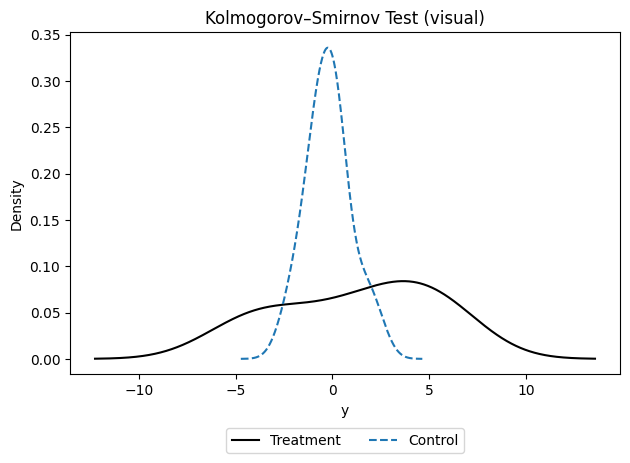

Estatística T_KS (aprox.): 0.500

Leitura:
  • O KS mede a maior distância vertical entre as CDFs empíricas de
    tratamento e controle.
  • O gráfico de densidade não é o KS em si, mas ajuda a intuir se as
    distribuições 'parecem' diferentes.
  • Em aplicações reais, poderíamos usar randomization inference ou
    resultados assintóticos para obter um p-value para T_KS.

=== p-values aproximados (Thornton HIV) ===
ATE observado (got ~ any): 0.4506
p-value aproximado via randomization inference: 0.0010

Leitura:
  • H0: incentivos não têm efeito algum sobre a probabilidade de buscar o resultado.
  • Reatribuímos o tratamento muitas vezes, mantendo o número de tratados.
  • Se poucas atribuições artificiais geram um ATE tão extremo quanto o observado,
    isso é evidência contra H0 (efeito diferente de zero).


In [30]:
if __name__ == "__main__":
    # 1. Regressão de Yule
    demo_yule_regression()

    # 2. Independência entre tratamento e outcomes potenciais
    demo_independence_assumption()

    # 3. Experimento da Dr. Bristol (tea tasting)
    demo_tea_tasting()

    # 4. Randomization inference (ri.dta)
    demo_randomization_inference()

    # 5. KS visual (gráfico + T_KS)
    demo_ks_visual()

    # 6. p-values aproximados (Thornton HIV)
    demo_approximate_p_values()